In [106]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import cv2
import numpy as np
import cv2.aruco

DEFAULT_FONT = 'Tahoma.ttf'
# Constants
#: standard DPI value in MS Word (allegedly)
STANDART_DPI = 72
SHEET_SIZE=(8.27, 11.69)
SHEET_MARGIN=(0.7, 0.4, 0.3, 0.05)
A4_SIZE = 35.08
HUMAN = 2
INDEX = 1

class FormDrawer:
    def __init__(self,  dpi=300, font_size=12, border_thickness=4):
        self.dpi = dpi
        self.font_size = font_size * self.dpi // STANDART_DPI
        #self.text_font = ImageFont.truetype('/Library/Fonts/', size=self.font_size)

        self.text_font = ImageFont.truetype('Library/Fonts/Helvetica.ttc', size=self.font_size, index = 1)
        self.text_color = "black"
        self.border_color = "black"
        self.background_color = (0, 0, 0)
        self.cursor = (150, 200) 
        self.sheet_size = (2480, 3508)
        self.cell_size = 90
        self.sheet_row = 230
        self.letters_position = []
        self.border_thickness = border_thickness
        # Preparing images and drawers
        self.images_array = []
        self.next_sheet(first_init=True)
        
    def next_row(self):
        self.cursor = ((150, self.cursor[1] + self.sheet_row))
        
    def next_sheet(self, first_init=False):
        if not first_init:
            self.images_array.append(self.form_image)
        self.letters_position.append(dict())
        self.form_image = Image.new('1', size=tuple(int(x * self.dpi) for x in SHEET_SIZE), color=255)
        self.form_image = self.form_image.convert('1')
        self.draw = ImageDraw.Draw(self.form_image)
        self.draw_cells()
        #self.draw_aruco_mark()
        self.cursor = (150, 200)
        
    def forward(self):
        if self.cursor[0] + self.cell_size < self.sheet_size[0] - 200:
            self.cursor = (self.cursor[0]+self.cell_size, self.cursor[1])
        else:
            if self.cursor[1] + self.sheet_row < self.sheet_size[1] - 200:
                self.next_row()
            else:
                self.next_sheet()
            
        
    def draw_text(self, text):
        if text in [" "]:
            if self.cursor[0] == 150:
                return
            self.forward()
            return
        
        self.draw_chart(self.cursor)
        self.letters_position[-1][self.cursor]= text[0] 
        #массив словарей; добавляем в последний словарь букву 0, т.к. она может идти со знаком препинания. ключ - координаты(левый верхний угол)
        w, h = self.draw.textsize(text, font=self.text_font)
        self.draw.text((self.cursor[0]+(self.cell_size-w)/2, self.cursor[1]-75), text, font=self.text_font, fill=self.text_color)
        
        self.forward()
        
        
    def save_position(self):
        with open("positions.pickle", "wb") as f:
            pickle.dump(self.letters_position, f)
        
    def draw_cells(self):
        self.draw_cell([(40, 40), (110, 110)])
        self.draw_cell([(2370, 40), (2440, 110)])
        self.draw_cell([(40, 3398), (110, 3468)])
        self.draw_cell([(2370, 3398), (2440, 3468)])
        
        
    def draw_cell(self, box):
        self.draw.rectangle(box, fill=self.border_color)
        new_pos = (box[1][0] + 20, box[1][1] + 20)
        rec_info = (box[1][0] - box[0][0], box[1][1]-box[0][1])
        return [new_pos, rec_info]
    
    def draw_aruco_mark(self, human):
        if self.cursor != (150, 200):
            self.images_array.append(self.form_image)
            self.cursor = (150, 200)
        page = 1
        Dictionary = cv2.aruco.getPredefinedDictionary( cv2.aruco.DICT_5X5_250)
        for i in range(len(self.images_array)):
            self.images_array[i] = np.array(self.images_array[i].convert("RGB"))
            self.images_array[i] = cv2.cvtColor(self.images_array[i], cv2.COLOR_BGR2GRAY)
            if page % 2 == 0:
                marker_numb_of_page = cv2.aruco.drawMarker(Dictionary,1,120,1)
            else:
                #human += 1
                marker_numb_of_page = cv2.aruco.drawMarker(Dictionary,0,120,1)
            marker_human = cv2.aruco.drawMarker(Dictionary,human,120,1)
            page += 1
            self.images_array[i][3348:3468, 400:520] = np.array(marker_numb_of_page)
            self.images_array[i][3348:3468, 1980:2100] = np.array(marker_human)
            self.images_array[i] = Image.fromarray(self.images_array[i].astype(np.int8)).convert("1")
    
    def draw_chart(self, draw_p):

        line = (draw_p, (draw_p[0] + 20, draw_p[1]))
        self.draw.line(line, fill = "black", width=5)

        line = (draw_p, (draw_p[0], draw_p[1] + 20))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0] + self.cell_size, draw_p[1]), (draw_p[0] + self.cell_size-20, draw_p[1]))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0] + self.cell_size, draw_p[1]), (draw_p[0] + self.cell_size, draw_p[1] + 20))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0] + self.cell_size, draw_p[1] + self.cell_size), (draw_p[0] + self.cell_size-20, draw_p[1] + self.cell_size))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0] + self.cell_size, draw_p[1] + self.cell_size), (draw_p[0] + self.cell_size, draw_p[1] + self.cell_size-20))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0], draw_p[1] + self.cell_size), (draw_p[0] + 20, draw_p[1] + self.cell_size))
        self.draw.line(line, fill = "black", width=5)

        line = ((draw_p[0], draw_p[1] + self.cell_size), (draw_p[0], draw_p[1] + self.cell_size-20))
        self.draw.line(line, fill = "black", width=5)

        newdrap_p = (draw_p[0] + self.cell_size, draw_p[1])
    
    def save_to_pdf(self, index):
        temp_array = list(self.images_array)
        temp_array.append(self.form_image)
        #temp_array = [i.convert("RGB") for i in temp_array]
        #temp_array[0].save('test1.pdf', save_all=True, append_images=temp_array[1:])
        #plt.imsave('test4.pdf', temp_array[0], cmap='gray')
        #plt.imsave('test5.pdf', temp_array[1], cmap='gray')
        for i in range(len(self.images_array)):
            plt.imsave('test{0}.pdf'.format(index), temp_array[i], cmap='gray')
            index += 1
    
    def show_image(self, **params):
        # TODO use params to set figure and other parameters
        temp_array = list(self.images_array)
        if self.cursor != (150, 200):
            temp_array.append(self.form_image)
        for l in temp_array:
            plt.figure(figsize = (A4_SIZE, 24.8))
            plt.imshow(l, cmap='gray')
            plt.title('Test', fontsize=28, color='#af0000')
        
# Further reading:
# https://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/
# http://sudokugrab.blogspot.com/2009/07/how-does-it-all-work.html

In [107]:
def parse_and_write(string, drawer):
    i = 0
    punctuation = [",", ".", "!", "?"]
    while i < len(string):
        j = 1
        while i+j < len(string) and string[i+j] in punctuation:
            j +=1
        drawer.draw_text(string[i:i+j])
        i += j

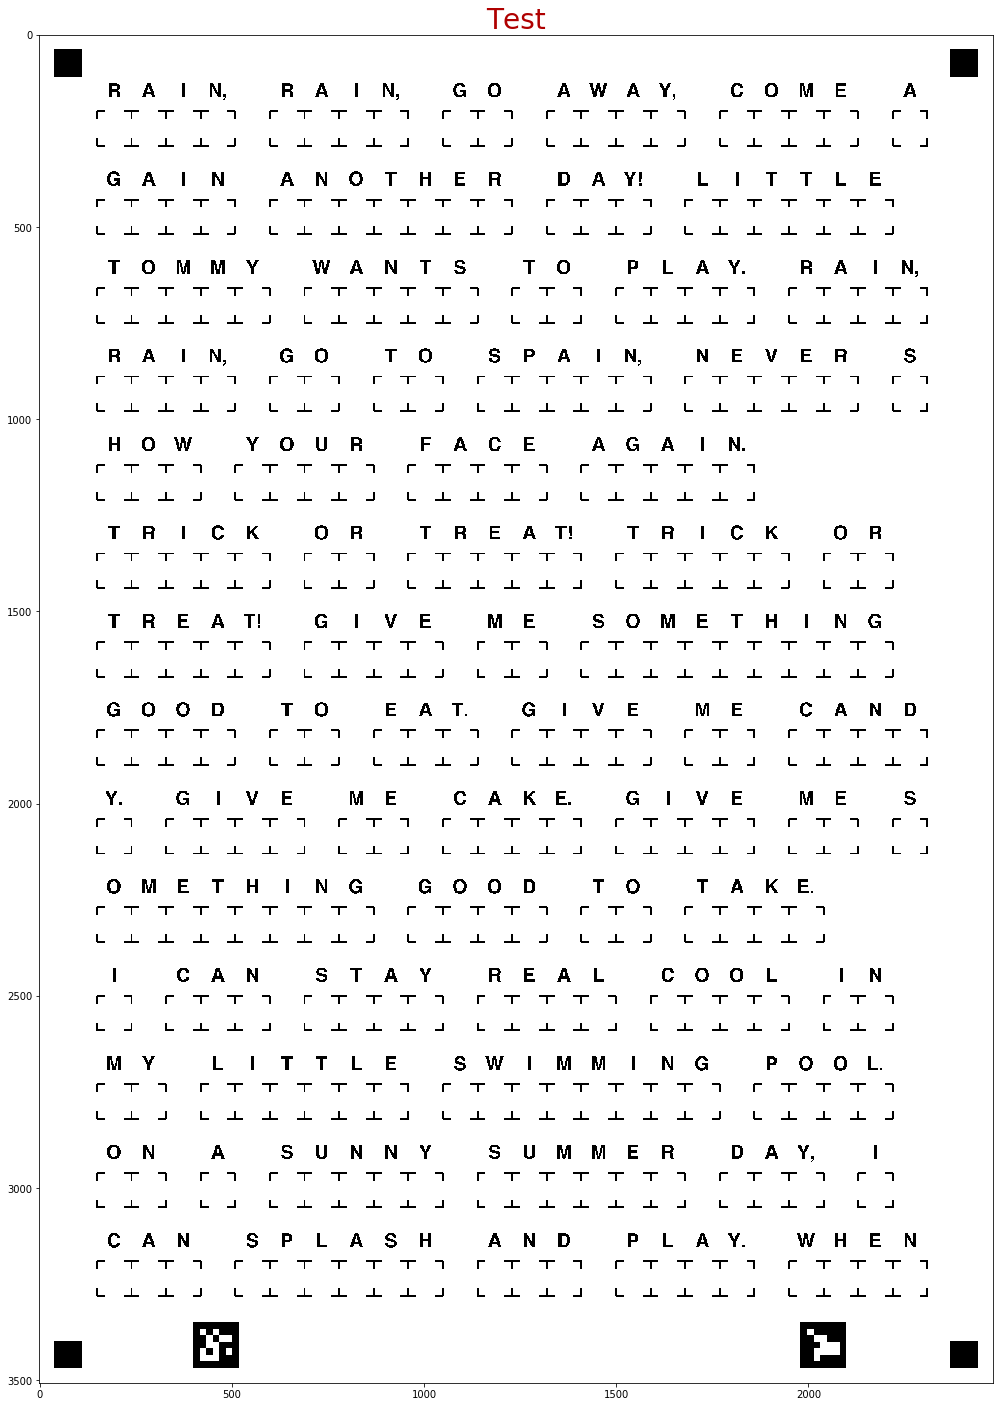

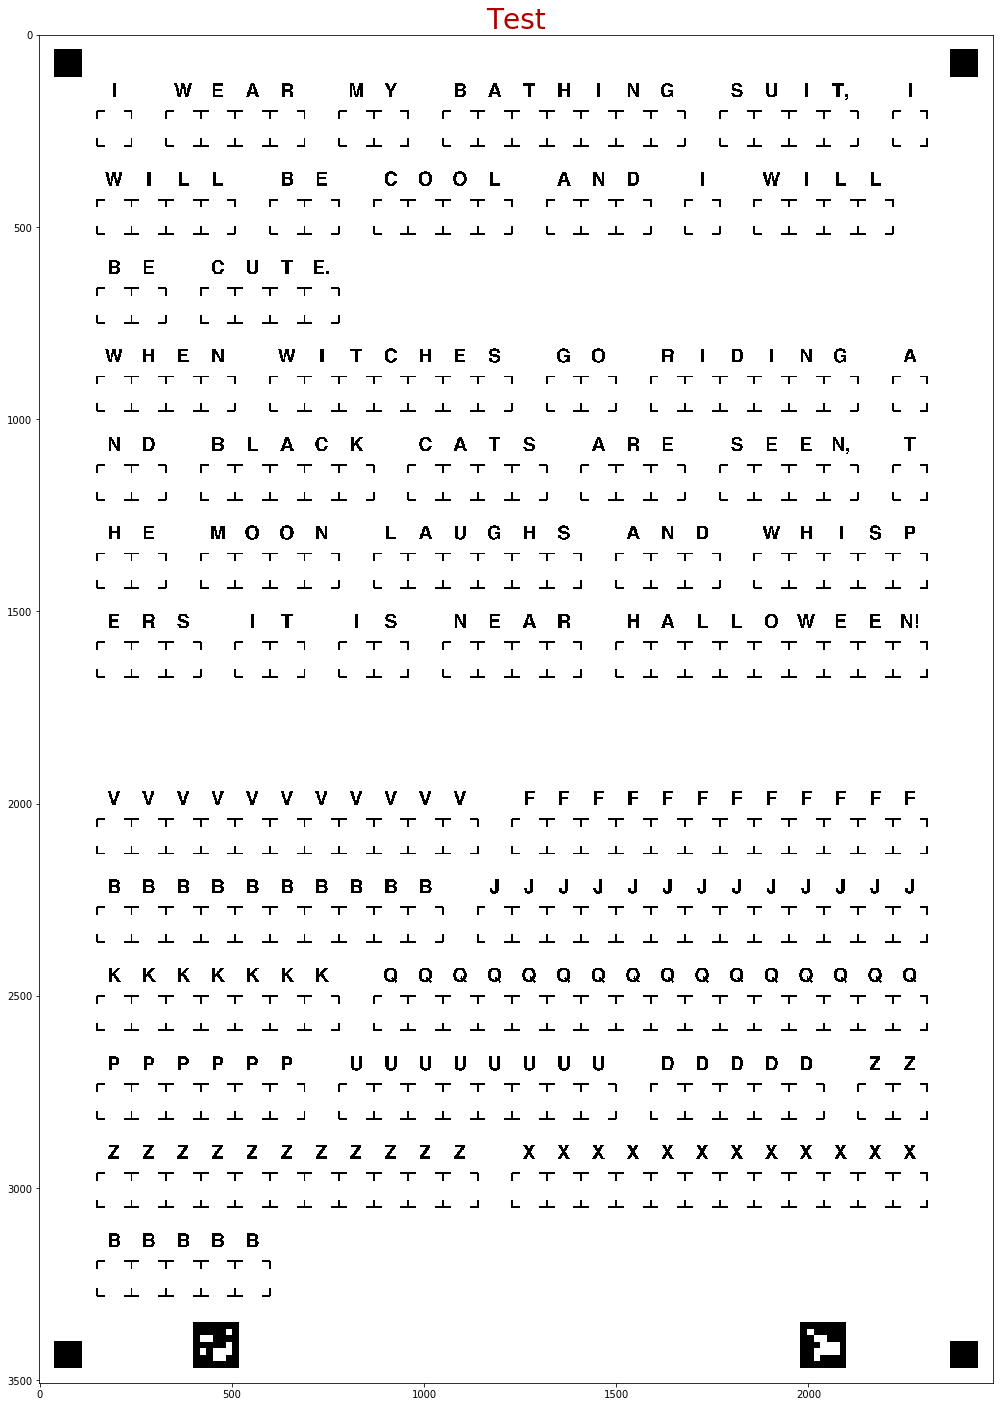

In [108]:
human = 19
index = 31
d = FormDrawer()

# d.draw_cells()
string4 = 'RAIN, RAIN, GO AWAY, COME AGAIN ANOTHER DAY! LITTLE TOMMY WANTS TO PLAY. RAIN, RAIN, GO TO SPAIN, NEVER SHOW YOUR FACE AGAIN.'
string0 = 'TRICK OR TREAT! TRICK OR TREAT! GIVE ME SOMETHING GOOD TO EAT. GIVE ME CANDY. GIVE ME CAKE. GIVE ME SOMETHING GOOD TO TAKE.'
string1 = ' I CAN STAY REAL COOL IN MY LITTLE SWIMMING POOL. ON A SUNNY SUMMER DAY, I CAN SPLASH AND PLAY. WHEN I WEAR MY BATHING SUIT, I WILL BE COOL AND I WILL BE CUTE.'
string3 = 'WHEN WITCHES GO RIDING AND BLACK CATS ARE SEEN, THE MOON LAUGHS AND WHISPERS IT IS NEAR HALLOWEEN!'
string2 = 'V'*11 + " " + 'F'*12 + ' ' + 'B'*10 + ' ' + 'J'*13 + ' ' + "K"*7 + ' ' + 'Q'*16 + "P"*6 + ' ' + "U"*8  + ' ' + 'D'*5 + ' ' + 'Z'*13 + ' ' + 'X'*12 + ' ' + 'B'*5


parse_and_write(string4, d)
d.next_row()

parse_and_write(string0, d)
d.next_row()

parse_and_write(string1, d)
d.next_row()

parse_and_write(string3, d)
d.next_row()

parse_and_write(string2, d)
d.draw_aruco_mark(human)
human += 1
d.show_image()
d.save_position()
#d.save_to_pdf(index)
index = index + 2

In [41]:
from string import ascii_lowercase as letters

string = (string4 + string1 + string2 + string0 + string3).lower()
count = 0

for i in letters:
    print(i, string.count(i))
    count += string.count(i)
data_values = [string.count(i)/count * 100 for i in letters]

a 42
b 19
c 14
d 15
e 39
f 13
g 17
h 13
i 35
j 13
k 12
l 19
m 16
n 32
o 30
p 12
q 16
r 20
s 19
t 29
u 14
v 16
w 12
x 12
y 12
z 13


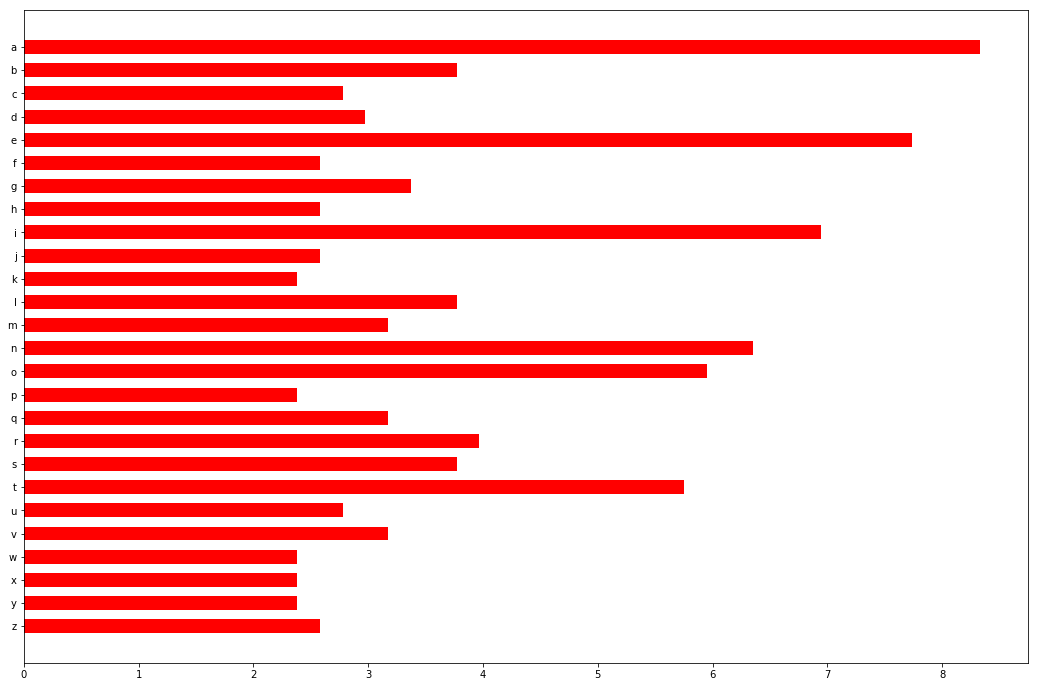

In [42]:
import matplotlib.pyplot as plt

data_names = letters

fig = plt.figure(figsize=(18,12))

xs = list(range(len(data_names)))[::-1]

plt.barh([x for x in xs], [ d for d in data_values],
         height = 0.6, color = 'red')
plt.yticks(xs, data_names)
plt.show()

In [7]:
string

'rain, rain, go away, come again another day! little tommy wants to play. rain, rain, go to spain, never show your face again. i can stay real cool in my little swimming pool. on a sunny summer day, i can splash and play. when i wear my bathing suit, i will be cool and i will be cute.vvvvvvvvvvv ffffffffffff bbbbbbbbbb jjjjjjjjjjjjj kkkkkkk qqqqqqqqqqqqqqqqpppppp uuuuuuuu ddddd zzzzzzzzzzzzz xxxxxxxxxxxx bbbbbtrick or treat! trick or treat! give me something good to eat. give me candy. give me cake. give me something good to take.when witches go riding and black cats are seen, the moon laughs and whispers it is near halloween!'

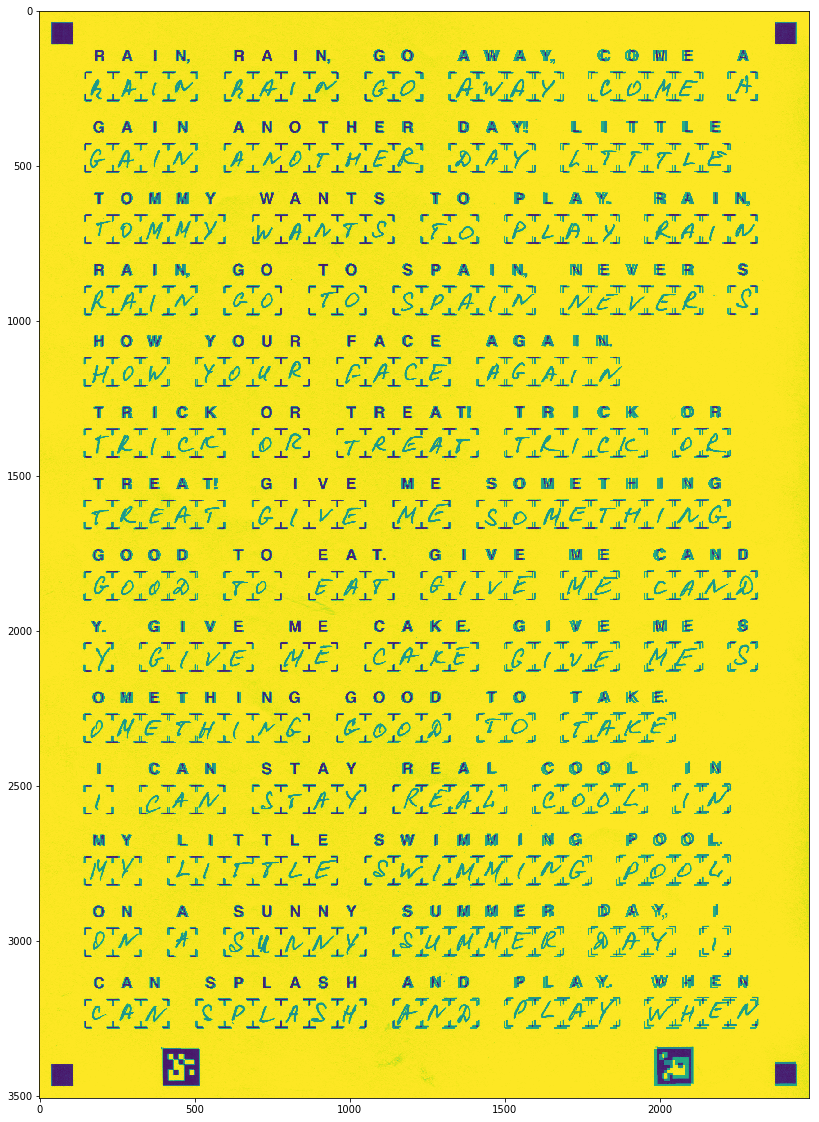

In [109]:
im = d.images_array[0]
im_gray = cv2.cvtColor(np.array(im.convert("RGB")), cv2.COLOR_BGR2GRAY)
dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

# dst_gray_b = dst_gray < 150
# im_gray_b = im_gray < 150

plt.figure(figsize=(20,20))
plt.imsave( "matching1.png", im_gray*0.6+dst_gray)
plt.imshow(im_gray *0.6 + dst_gray)

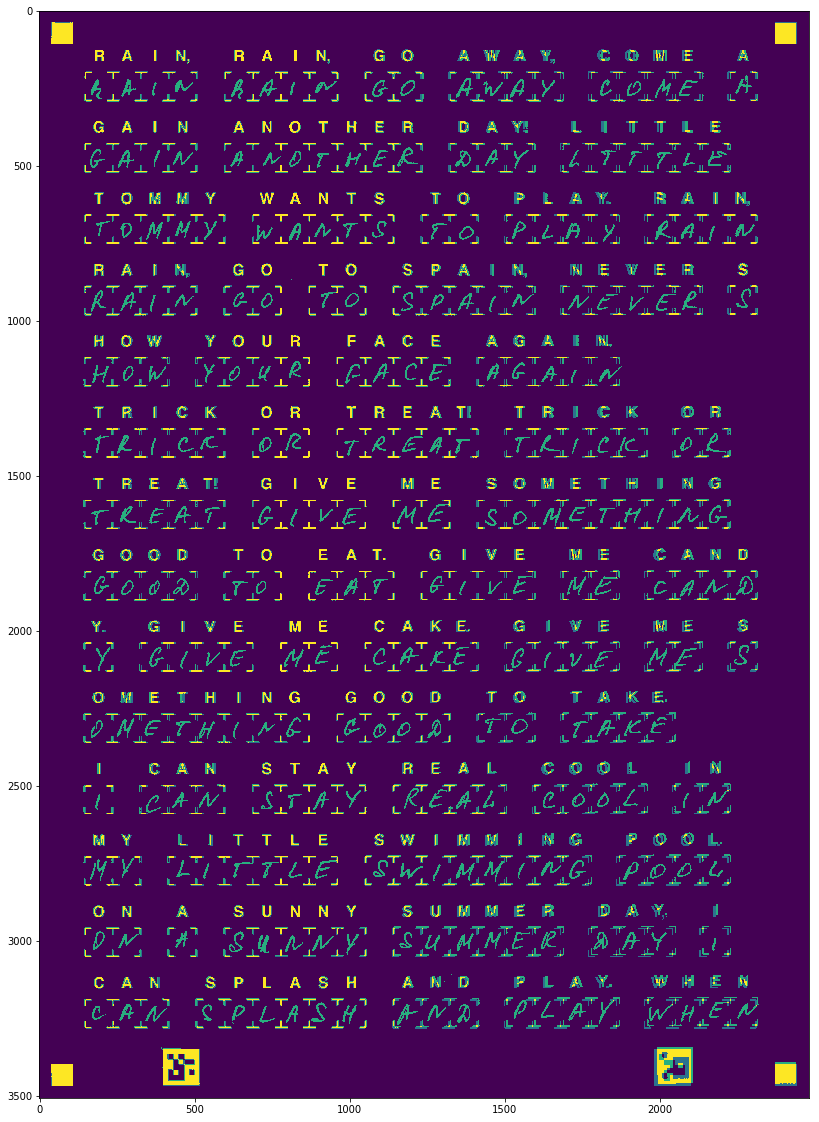

In [110]:
dst_gray_b = dst_gray < 150
im_gray_b = im_gray < 150

plt.figure(figsize=(20,20))
plt.imshow(im_gray_b*0.6+dst_gray_b)